In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split

import lightgbm as lgb
from sklearn.metrics import roc_auc_score

import matplotlib.pylab as plt

In [2]:
df = pd.read_csv('solar data.csv')

# Step 3: Quick look at data
print("Shape of dataset:", df.shape)
print(df.head())

print(df.columns)

Shape of dataset: (4213, 21)
   temperature_2_m_above_gnd  relative_humidity_2_m_above_gnd  \
0                       2.17                               31   
1                       2.31                               27   
2                       3.65                               33   
3                       5.82                               30   
4                       7.73                               27   

   mean_sea_level_pressure_MSL  total_precipitation_sfc  snowfall_amount_sfc  \
0                       1035.0                      0.0                  0.0   
1                       1035.1                      0.0                  0.0   
2                       1035.4                      0.0                  0.0   
3                       1035.4                      0.0                  0.0   
4                       1034.4                      0.0                  0.0   

   total_cloud_cover_sfc  high_cloud_cover_high_cld_lay  \
0                    0.0                

In [3]:

# Step 4: Split into features (X) and target (y)
X = df.drop('generated_power_kw', axis=1)  # all input columns
y = df['generated_power_kw']               # target column

# Step 5: Split into train and test (80% train, 20% test)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 6: Split training set into actual training and validation (80/20)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

print("Train set shape:", X_train.shape)
print("Validation set shape:", X_valid.shape)
print("Test set shape:", X_test.shape)

# Step 7: Create LightGBM Datasets
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)


Train set shape: (2696, 20)
Validation set shape: (674, 20)
Test set shape: (843, 20)


In [4]:

#setting parameters to the model
params = {
    'objective': 'regression',   # because you are predicting a continuous number
    'metric': 'rmse',            # evaluation metric (Root Mean Squared Error)
    'boosting_type': 'gbdt',     # gradient boosting decision tree
    'learning_rate': 0.05,       # smaller = slower but more accurate
    'num_leaves': 31,            # tree complexity
    'verbose': -1                # suppress extra output
}

In [5]:
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, valid_data],
    valid_names=['train','valid'],
    callbacks=[lgb.early_stopping(stopping_rounds=50),
               lgb.log_evaluation(period=50)]
)

Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 340.859	valid's rmse: 467.133
[100]	train's rmse: 261.976	valid's rmse: 437.785
[150]	train's rmse: 222.264	valid's rmse: 430.229
[200]	train's rmse: 190.792	valid's rmse: 429.793
Early stopping, best iteration is:
[191]	train's rmse: 195.707	valid's rmse: 429.324


In [6]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)


In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import numpy as np

# MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.3f}")

# RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

# MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.3f}")

#R2 SCORE
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.3f}")

Mean Squared Error (MSE): 154959.048
Root Mean Squared Error (RMSE): 393.648
Mean Absolute Error (MAE): 250.547
R² Score: 0.830


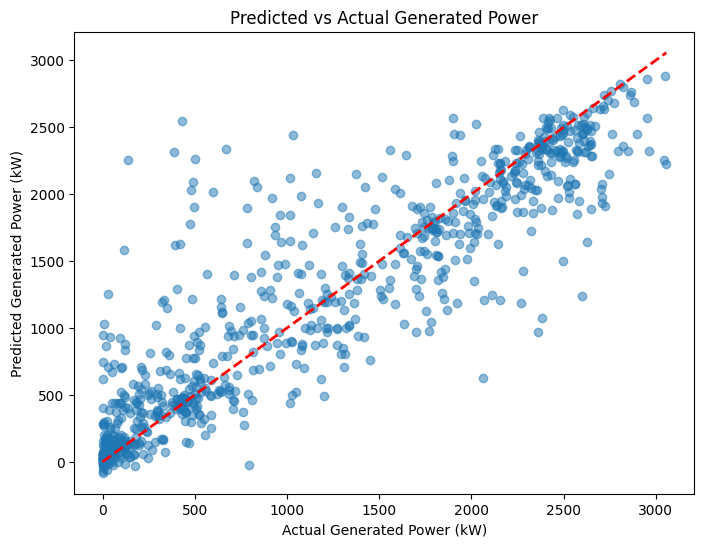

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Generated Power (kW)')
plt.ylabel('Predicted Generated Power (kW)')
plt.title('Predicted vs Actual Generated Power')
plt.show()